

- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기



In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
data=load_digits()

In [3]:
input = data.data
output = data.target

In [4]:
data.images[1796]

array([[ 0.,  0., 10., 14.,  8.,  1.,  0.,  0.],
       [ 0.,  2., 16., 14.,  6.,  1.,  0.,  0.],
       [ 0.,  0., 15., 15.,  8., 15.,  0.,  0.],
       [ 0.,  0.,  5., 16., 16., 10.,  0.,  0.],
       [ 0.,  0., 12., 15., 15., 12.,  0.,  0.],
       [ 0.,  4., 16.,  6.,  4., 16.,  6.,  0.],
       [ 0.,  8., 16., 10.,  8., 16.,  8.,  0.],
       [ 0.,  1.,  8., 12., 14., 12.,  1.,  0.]])

In [5]:
output[1796]

8

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [8]:
print(x_train[0])
print(y_train[0])

#input 64개 (속성이 64개: 각 픽셀이 16색을 가지는 8 X 8 개의 속성 )
#y의 class는 10개 (0 ~ 9 까지의 숫자)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.], device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [9]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [10]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [11]:
model = nn.Sequential(
    nn.Linear(64, 128), # input_layer = 64, hidden_layer1 = 128
    nn.Sigmoid(),
    nn.Linear(128, 256), # hidden_layer1 = 128, hidden_layer2 = 256
    nn.Sigmoid(),
    nn.Linear(256, 64), # hidden_layer2 = 256, hidden_layer3 = 64
    nn.Sigmoid(),
    nn.Linear(64, 10) # hidden_layer3 = 64, output_layer = 10
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

#1. Sigmoid


## 1.1. Sigmoid ( optimizer: Adam)


In [12]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          nn.Sigmoid(),
        nn.BatchNorm1d(128)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [13]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [14]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [15]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [16]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [17]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3040900230407715
10 1.7217371463775635
20 1.5772038698196411
30 1.5637599229812622
40 1.5143775939941406
50 1.4683605432510376
60 1.464194416999817
70 1.4633677005767822
80 1.4626290798187256
90 1.4624497890472412


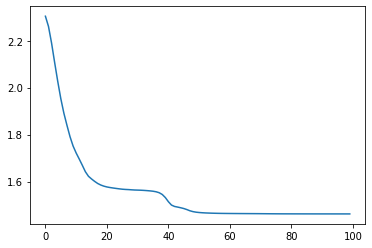

In [18]:
plt.plot(losses)
plt.show()

In [19]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [20]:
np.set_printoptions(precision=6, suppress=True)


In [21]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'sigmoid(Adam)의 accuracy는 {accuracy}')

model의 output은 :  [0.000028 0.999298 0.000095 0.000068 0.00024  0.000028 0.000055 0.000104
 0.000065 0.000019]
argmax를 한 후의 output은 1
sigmoid(Adam)의 accuracy는 0.9685185185185186


## 1.2. Sigmoid ( optimizer: SGD)


In [22]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          nn.Sigmoid(),
        nn.BatchNorm1d(128)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [23]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [24]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [25]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [26]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)



In [27]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3026845455169678
10 2.298443078994751
20 2.2892861366271973
30 2.2750840187072754
40 2.2509405612945557
50 2.20857572555542
60 2.1488444805145264
70 2.0938503742218018
80 2.056295394897461
90 2.0215816497802734


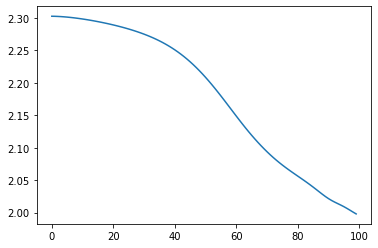

In [28]:
plt.plot(losses)
plt.show()

In [29]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [30]:
np.set_printoptions(precision=6, suppress=True)


In [31]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'Sigmoid(SGD)의 accuracy는 {accuracy}')

model의 output은 :  [0.022248 0.645913 0.008568 0.147678 0.006604 0.014047 0.107691 0.012831
 0.02324  0.01118 ]
argmax를 한 후의 output은 1
Sigmoid(SGD)의 accuracy는 0.48703703703703705


#2. ReLu

## 2.1. ReLu (optimizer: Adam)

In [32]:

class ReLU(torch.nn.ReLU):
  def forward(self, x):
    return torch.max(torch.zeros_like(x), x)

In [33]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          ReLU(),
        nn.BatchNorm1d(128)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [34]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [35]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [36]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [37]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [38]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.310030937194824
10 1.4740034341812134
20 1.4668631553649902
30 1.465137243270874
40 1.465077519416809
50 1.4645001888275146
60 1.4642733335494995
70 1.464269757270813
80 1.4642682075500488
90 1.4642373323440552


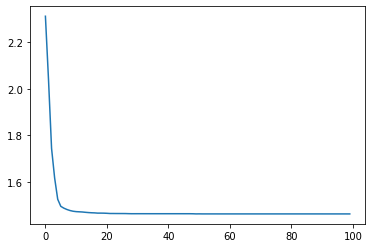

In [39]:
plt.plot(losses)
plt.show()

In [40]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [41]:
np.set_printoptions(precision=6, suppress=True)


In [42]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'ReLu (Adam)의 accuracy는 {accuracy}')

model의 output은 :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 1
ReLu (Adam)의 accuracy는 0.9722222222222222


## 2.2. ReLu( optimizer: SGD)


In [43]:

class ReLU(torch.nn.ReLU):
  def forward(self, x):
    return torch.max(torch.zeros_like(x), x)

In [44]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          ReLU(),
        nn.BatchNorm1d(128)
    )


    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [45]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [46]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [47]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [48]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)



In [49]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 2.301802396774292


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.0109148025512695
20 1.6671217679977417
30 1.5301518440246582
40 1.4928513765335083
50 1.4800008535385132
60 1.4740078449249268
70 1.4703463315963745
80 1.4680149555206299
90 1.4668182134628296


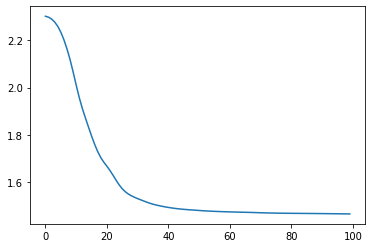

In [50]:
plt.plot(losses)
plt.show()

In [51]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [52]:
np.set_printoptions(precision=6, suppress=True)


In [53]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'ReLu (SGD)의 accuracy는 {accuracy}')

model의 output은 :  [0.       0.999988 0.000001 0.       0.       0.000002 0.000001 0.
 0.000007 0.000001]
argmax를 한 후의 output은 1
ReLu (SGD)의 accuracy는 0.9777777777777777


#3. tanh

## 3.1. tanh (optimizer: Adam)


In [54]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          nn.Tanh(),
        nn.BatchNorm1d(128)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
          nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
          nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [55]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [56]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [57]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [58]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.318458318710327
10 1.472385048866272
20 1.4655030965805054
30 1.4645066261291504
40 1.4640532732009888
50 1.462843656539917
60 1.4620699882507324
70 1.4620213508605957
80 1.461999773979187
90 1.4619895219802856


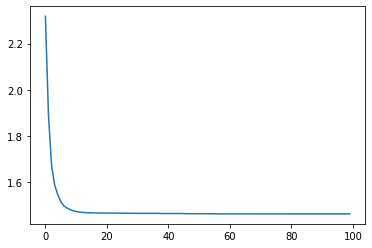

In [59]:
plt.plot(losses)
plt.show()

In [60]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [61]:
np.set_printoptions(precision=6, suppress=True)


In [62]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'tanh (Adam)의 accuracy는 {accuracy}')

model의 output은 :  [0.       0.999794 0.000014 0.       0.000028 0.000009 0.000114 0.000001
 0.000038 0.000001]
argmax를 한 후의 output은 1
tanh (Adam)의 accuracy는 0.9722222222222222


## 3.2. tanh (optimizer: SGD)


In [63]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64, 128),
          nn.Tanh(),
        nn.BatchNorm1d(128)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(128,256, bias=True), 
          nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256,64, bias=True),
          nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [64]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [65]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [66]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [67]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3050384521484375
10 1.4715697765350342
20 1.463465690612793
30 1.4621632099151611
40 1.4620741605758667
50 1.462023377418518
60 1.4620039463043213
70 1.4619908332824707
80 1.4612078666687012
90 1.461204171180725


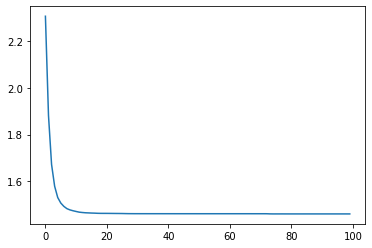

In [68]:
plt.plot(losses)
plt.show()

In [69]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [70]:
np.set_printoptions(precision=6, suppress=True)


In [71]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'tanh (SGD)의 accuracy는 {accuracy}')

model의 output은 :  [0.       0.999974 0.000001 0.       0.000001 0.       0.000001 0.000001
 0.000016 0.000004]
argmax를 한 후의 output은 1
tanh (SGD)의 accuracy는 0.9740740740740741


###무식하게 반복해본 결과...

Sigmoid (Adam)의 accuracy는 0.9685185185185186

Sigmoid (SGD)의 accuracy는 0.48703703703703705

ReLu (Adam)의 accuracy는 0.9722222222222222

**ReLu (SGD)의 accuracy는 0.9777777777777777**

tanh (Adam)의 accuracy는 0.9722222222222222

tanh (SGD)의 accuracy는 0.9740740740740741




으로 ReLu를 주된 활성화함수로 모델을 만들고 optimizer를 SGD로 했을 때 auc 가 0.977으로 가장 높았다.